In [3]:
# This script reproduces the Ray tutorial with client2.
# Source: https://colab.research.google.com/github/ray-project/ray-educational-materials/blob/main/Computer_vision_workloads/Semantic_segmentation/Scaling_model_training_colab.ipynb#scrollTo=0UVZ2IBjuAxd

In [1]:
import json
import warnings

import torch
import numpy as np
import pandas as pd

from typing import Union
from datasets.arrow_dataset import Dataset
from huggingface_hub import hf_hub_download
from matplotlib import pyplot as plt
from PIL import Image
from PIL.JpegImagePlugin import JpegImageFile


warnings.simplefilter("ignore")

In [2]:
import ray
from ray.experimental.client2.client import Client as Client2

In [3]:
client = Client2("http://localhost:8265", "your_channel_name", runtime_env={"pip":["torch", "transformers", "datasets"]})

2023-11-20 21:39:47,249	INFO client.py:414 -- client2 channel not connected, maybe the ClientSupervisor is still starting...
2023-11-20 21:39:52,306	INFO client.py:205 -- client2 channel your_channel_name connected!


In [4]:
@ray.remote
def set_seed(seed):
    torch.manual_seed(seed)
    
client.task(set_seed).remote(201)

ObjectRef(f227d514c661b66fffffffffffffffffffffffff0400000001000000)

In [5]:
# Step 1. load data. The colab used a HF dataset that downloads to local disk and then reads them to
# the Python driver script. We do the same thing, only the last step we upload via client.put.

# https://huggingface.co/datasets/huggingface/label-files/blob/main/ade20k-id2label.json
def get_labels():
    repo_id = "huggingface/label-files"
    filename = "ade20k-id2label.json"
    id2label = json.load(
        open(
            hf_hub_download(repo_id=repo_id, filename=filename, repo_type="dataset"),
            "r",
        )
    )

    id2label = {int(k): v for k, v in id2label.items()}
    label2id = {v: k for k, v in id2label.items()}
    return id2label, label2id

In [6]:
id2label, label2id = get_labels()
num_labels = len(id2label)

id2label_ref = client.put(id2label)
label2id_ref = client.put(label2id)

print(f"Total number of labels: {len(id2label)}")
print(f"Example labels: {list(id2label.values())[:5]}")

Total number of labels: 150
Example labels: ['wall', 'building', 'sky', 'floor', 'tree']


In [7]:
# You can use `client.run` to remotely invoke methods on non-Ray modules and objects, returning an ObjectRef.
# It requires more keystrokes but it's dead clear where each piece of code is run.


from transformers import SegformerForSemanticSegmentation
# "nvidia/mit-b0"                              https://huggingface.co/nvidia/mit-b0
# "nvidia/segformer-b0-finetuned-ade-512-512"  https://huggingface.co/nvidia/segformer-b0-finetuned-ade-512-512

MODEL_NAME = "nvidia/mit-b0"

segformer = client.run(SegformerForSemanticSegmentation).from_pretrained(
    MODEL_NAME, id2label=id2label, label2id=label2id
)

print(f"Number of model parameters: {client.get(client.run(segformer).num_parameters())/(10**6):.2f} M")

Number of model parameters: 3.75 M


In [8]:
segformer

ObjectRef(bc0191240f8f272cffffffffffffffffffffffff0400000001000000)

In [9]:
# Load data from the Hugging Face datasets repository.
# This is kinda heavy so we directly load in a Ray remote function.

from datasets import load_dataset
SMALL_DATA = True
DATASET_NAME = "scene_parse_150"


@ray.remote
def load_data():
    # TODO: we need to forward HF prints to the client. Here we only have silence.
    # This may because HF detects interactive
    if SMALL_DATA:
         return load_dataset(DATASET_NAME, split="train[:160]")
    else:
         return load_dataset(DATASET_NAME, split="train")
        
train_dataset = client(load_data).remote()

In [10]:
# You can use `client.run` to easily run methods on non-Actor objects

def convert_image_to_rgb(data_item):
    if data_item["image"].mode != "RGB":
        data_item["image"] = data_item["image"].convert(mode="RGB")

    return data_item

train_dataset = client.run(train_dataset).map(convert_image_to_rgb)
train_dataset

ObjectRef(4eb84cedf51a7881ffffffffffffffffffffffff0400000001000000)

In [11]:
# A colormap for visualizing segmentation results.
# https://github.com/tensorflow/models/blob/3f1ca33afe3c1631b733ea7e40c294273b9e406d/research/deeplab/utils/get_dataset_colormap.py#L51
# (date accessed: Nov 9th, 2022)
ade_palette = np.array(
    [
        [0, 0, 0],
        [120, 120, 120],
        [180, 120, 120],
        [6, 230, 230],
        [80, 50, 50],
        [4, 200, 3],
        [120, 120, 80],
        [140, 140, 140],
        [204, 5, 255],
        [230, 230, 230],
        [4, 250, 7],
        [224, 5, 255],
        [235, 255, 7],
        [150, 5, 61],
        [120, 120, 70],
        [8, 255, 51],
        [255, 6, 82],
        [143, 255, 140],
        [204, 255, 4],
        [255, 51, 7],
        [204, 70, 3],
        [0, 102, 200],
        [61, 230, 250],
        [255, 6, 51],
        [11, 102, 255],
        [255, 7, 71],
        [255, 9, 224],
        [9, 7, 230],
        [220, 220, 220],
        [255, 9, 92],
        [112, 9, 255],
        [8, 255, 214],
        [7, 255, 224],
        [255, 184, 6],
        [10, 255, 71],
        [255, 41, 10],
        [7, 255, 255],
        [224, 255, 8],
        [102, 8, 255],
        [255, 61, 6],
        [255, 194, 7],
        [255, 122, 8],
        [0, 255, 20],
        [255, 8, 41],
        [255, 5, 153],
        [6, 51, 255],
        [235, 12, 255],
        [160, 150, 20],
        [0, 163, 255],
        [140, 140, 140],
        [250, 10, 15],
        [20, 255, 0],
        [31, 255, 0],
        [255, 31, 0],
        [255, 224, 0],
        [153, 255, 0],
        [0, 0, 255],
        [255, 71, 0],
        [0, 235, 255],
        [0, 173, 255],
        [31, 0, 255],
        [11, 200, 200],
        [255, 82, 0],
        [0, 255, 245],
        [0, 61, 255],
        [0, 255, 112],
        [0, 255, 133],
        [255, 0, 0],
        [255, 163, 0],
        [255, 102, 0],
        [194, 255, 0],
        [0, 143, 255],
        [51, 255, 0],
        [0, 82, 255],
        [0, 255, 41],
        [0, 255, 173],
        [10, 0, 255],
        [173, 255, 0],
        [0, 255, 153],
        [255, 92, 0],
        [255, 0, 255],
        [255, 0, 245],
        [255, 0, 102],
        [255, 173, 0],
        [255, 0, 20],
        [255, 184, 184],
        [0, 31, 255],
        [0, 255, 61],
        [0, 71, 255],
        [255, 0, 204],
        [0, 255, 194],
        [0, 255, 82],
        [0, 10, 255],
        [0, 112, 255],
        [51, 0, 255],
        [0, 194, 255],
        [0, 122, 255],
        [0, 255, 163],
        [255, 153, 0],
        [0, 255, 10],
        [255, 112, 0],
        [143, 255, 0],
        [82, 0, 255],
        [163, 255, 0],
        [255, 235, 0],
        [8, 184, 170],
        [133, 0, 255],
        [0, 255, 92],
        [184, 0, 255],
        [255, 0, 31],
        [0, 184, 255],
        [0, 214, 255],
        [255, 0, 112],
        [92, 255, 0],
        [0, 224, 255],
        [112, 224, 255],
        [70, 184, 160],
        [163, 0, 255],
        [153, 0, 255],
        [71, 255, 0],
        [255, 0, 163],
        [255, 204, 0],
        [255, 0, 143],
        [0, 255, 235],
        [133, 255, 0],
        [255, 0, 235],
        [245, 0, 255],
        [255, 0, 122],
        [255, 245, 0],
        [10, 190, 212],
        [214, 255, 0],
        [0, 204, 255],
        [20, 0, 255],
        [255, 255, 0],
        [0, 153, 255],
        [0, 41, 255],
        [0, 255, 204],
        [41, 0, 255],
        [41, 255, 0],
        [173, 0, 255],
        [0, 245, 255],
        [71, 0, 255],
        [122, 0, 255],
        [0, 255, 184],
        [0, 92, 255],
        [184, 255, 0],
        [0, 133, 255],
        [255, 214, 0],
        [25, 194, 194],
        [102, 255, 0],
        [92, 0, 255],
    ]
)

In [12]:
def prepare_pixels_with_segmentation(
    image: JpegImageFile, segmentation_maps: Union[torch.Tensor, np.array]
):
    segmentation_maps = np.array(segmentation_maps)
    color_segments = np.zeros(
        (segmentation_maps.shape[0], segmentation_maps.shape[1], 3), dtype=np.uint8
    )
    for label, color in enumerate(ade_palette):
        color_segments[segmentation_maps == label, :] = color
    color_segments = color_segments[..., ::-1]  # convert to BGR
    pixels_with_segmentation = np.array(image) * 0.5 + color_segments * 0.5
    return pixels_with_segmentation.astype(np.uint8)

In [14]:
# When it comes to interactive printing, and plotting it has to come back to the local. 
# Still we want an explicit notion of what happens where.

@ray.remote
def get_nxn_images(dataset: Dataset, n: int = 2):
    ret = []
    for i, j in enumerate(
        np.random.choice(dataset.num_rows, size=(n * n), replace=False)
    ):
        image_with_pixels = prepare_pixels_with_segmentation(
            image=dataset[int(j)]["image"],
            segmentation_maps=np.array(dataset[int(j)]["annotation"]),
        )  
        ret.append(image_with_pixels)
    return ret

def display_example_images(dataset: "ray.ObjectRef[Dataset]", n: int = 2):
    fig, axes = plt.subplots(nrows=n, ncols=n, figsize=(10, 10))
    fig.set_tight_layout(True)
    imgs = client.get(client(get_nxn_images).remote(dataset, n))
    for i, img in enumerate(imgs):
        axes[int(i / n), i % n].imshow(img)
        axes[int(i / n), i % n].axis("off")

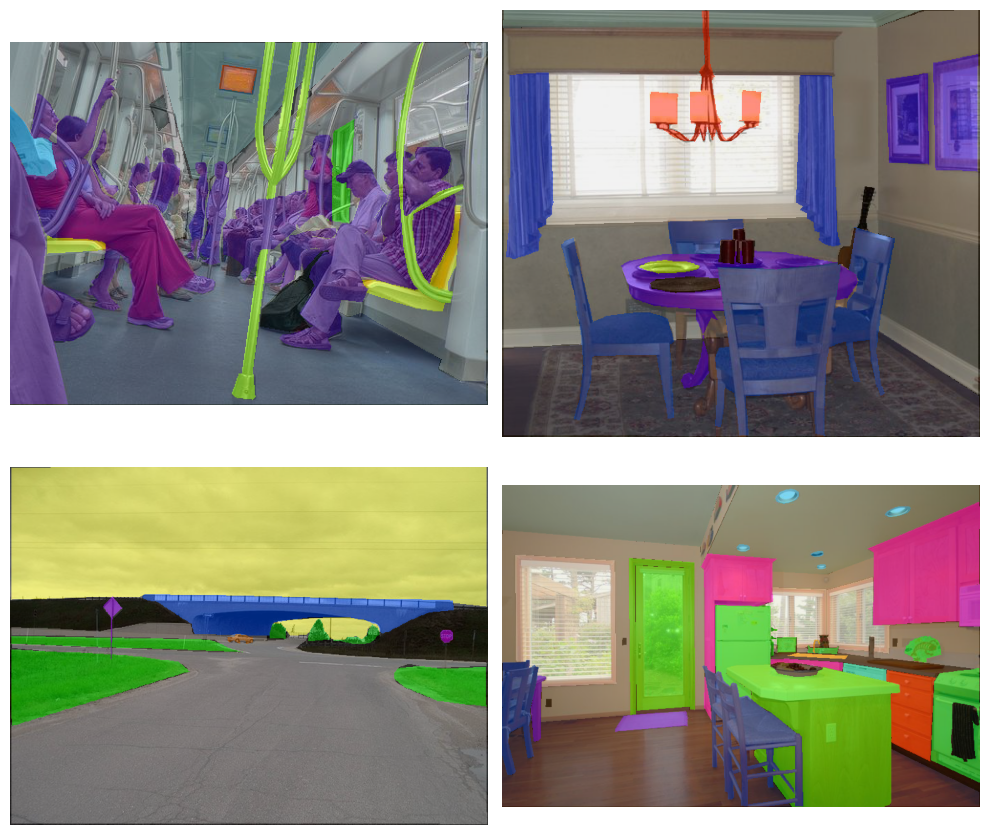

In [15]:
display_example_images(train_dataset)

In [16]:
BATCH_SIZE = 8
N_BATCHES = 1

In [17]:
def get_image_indices(dataset: Dataset, n: int):
    image_indices = np.random.choice(dataset.num_rows, size=n, replace=False)
    print(f"get_image_indices {image_indices}")
    return [int(i) for i in image_indices]

In [18]:
@ray.remote
def make_train_ds(dataset: Dataset, n: int):
    # Get BATCH_SIZE * N_BATCHES randomly shuffled image IDs from the train dataset.
    image_indices = get_image_indices(dataset=dataset, n=n)

    # Create a list of tuples (image, label) for the indices sampled from the train dataset.
    data = [
        {"image": dataset[i]["image"], "annotation": dataset[i]["annotation"]} for i in image_indices
    ]
    print(len(data))
    # Create a Ray Dataset from the list of images to use in Ray AIR.
    return ray.data.from_items(data)

In [19]:
train_ds = client(make_train_ds).remote(train_dataset,n=BATCH_SIZE * N_BATCHES)

In [20]:
client.get(client.run(train_ds).schema())

Column      Type
------      ----
image       <class 'object'>
annotation  <class 'object'>

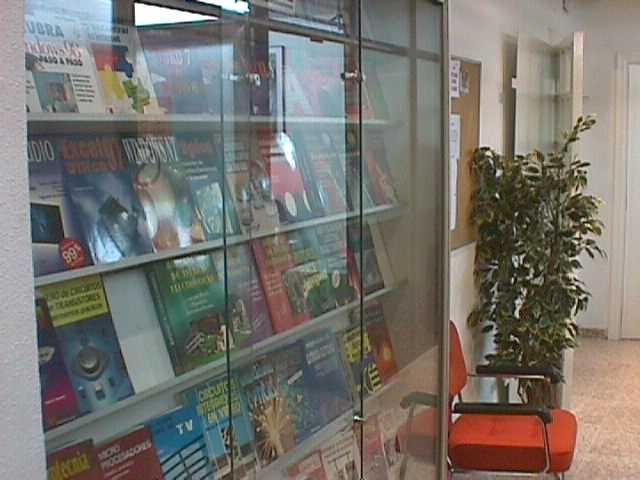

In [21]:
client.get(client.run(train_ds).take(1))[0]["image"]

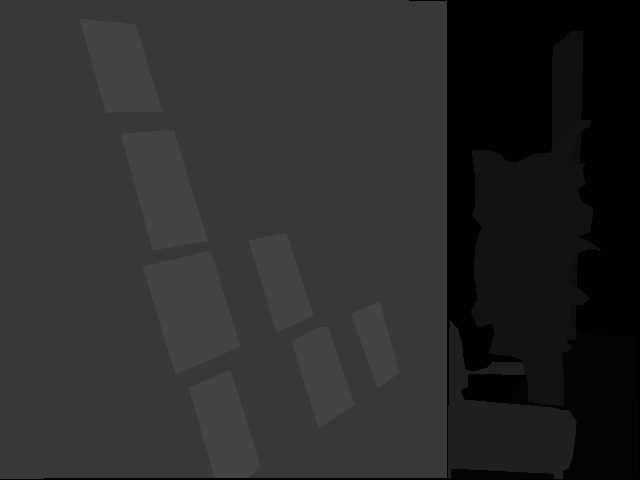

In [22]:
client.get(client.run(train_ds).take(1))[0]["annotation"]

In [23]:
def images_preprocessor(batch):
    from transformers import SegformerImageProcessor
    warnings.simplefilter("ignore")
    segformer_image_processor = SegformerImageProcessor.from_pretrained(
        MODEL_NAME, do_reduce_labels=True
    )

    # inputs are `transformers.image_processing_utils.BatchFeature`
    inputs = segformer_image_processor(
        images=list(batch["image"]),
        segmentation_maps=list(batch["annotation"]),
        return_tensors="np",
    )

    return dict(inputs)  # {"pixel_values": array, "labels": array}

In [24]:
from ray.data.preprocessors import BatchMapper

In [25]:
batch_preprocessor = BatchMapper(
    fn=images_preprocessor, batch_format="pandas", batch_size=2
)

In [26]:
from transformers import Trainer, TrainingArguments
from ray.train.huggingface.transformers import (
    RayTrainReportCallback,
    prepare_trainer,
)

In [27]:
### The original colab uses ray 2.3.0 and HuggingFaceTrainer. I tried to adapt the code to the new Trainer API
### But it looks like still have problems. Did not dig deep.

def train_func(config):
    warnings.simplefilter("ignore")

    name = "segformer-finetuned"

    # Setup model
    segformer = SegformerForSemanticSegmentation.from_pretrained(
        MODEL_NAME, id2label=id2label, label2id=label2id
    )

    # Setup optimizer and LR scheduler
    optimizer = torch.optim.AdamW(params=segformer.parameters(), lr=1e-4)
    lr_scheduler = torch.optim.lr_scheduler.LambdaLR(
        optimizer=optimizer, lr_lambda=lambda x: x
    )

    # Setup HF Training Arguments
    training_args = TrainingArguments(
        name,
        num_train_epochs=5,
        per_device_train_batch_size=BATCH_SIZE,
        save_total_limit=3,
        save_strategy="epoch",
        logging_strategy="epoch",
        eval_accumulation_steps=2,
        log_level="error",
        log_level_replica="error",
        log_on_each_node=False,
        remove_unused_columns=False,
        push_to_hub=False,
        disable_tqdm=True,  # declutter the output a little
        no_cuda=True,
    )

    # Setup HF Trainer
    trainer = Trainer(
        model=segformer,
        optimizers=(optimizer, lr_scheduler),
        args=training_args,
        train_dataset=   ray.train.get_dataset_shard("train"),
    )
    # [3] Inject Ray Train Report Callback
    # ====================================
    trainer.add_callback(RayTrainReportCallback())

    # [4] Prepare your trainer
    # ========================
    trainer = prepare_trainer(trainer)
    trainer.train()


In [28]:
from ray.train.huggingface import HuggingFaceTrainer
from ray.air.config import RunConfig, ScalingConfig, CheckpointConfig

In [29]:
# setup parameters for the ScalingConfig
num_workers = 1
use_gpu = False
scaling_config = ScalingConfig(num_workers=1, use_gpu=False)


In [30]:
# Setup Ray's HF Trainer
# DeprecationWarning: The TransformersTransformers will be hard deprecated in Ray 2.8. Use TorchTrainer instead. See https://docs.ray.io/en/releases-2.7.0/train/getting-started-transformers.html#transformerstrainer-migration-guide for more details.
from ray.train.torch import TorchTrainer

@ray.remote
def make_trainer():
    trainer = TorchTrainer(
        train_func,
        scaling_config=scaling_config,
        datasets={"train": ray.get(train_ds)},
    )
    return trainer

In [31]:
trainer  = client.task(make_trainer).remote()

In [32]:
result = client.run(trainer).fit()

In [33]:
# 3not caused by your own application logic, but rather an error such as OOM), you can restart the run from scratch or continue this run.
client.get(result)


HTTPError: 500 Server Error: Internal Server Error for url: http://localhost:8265/api/clients/ray_client2_actor_your_channel_name/get